In [8]:
#Data Download directory

dir="/home/advaita/Downloads/data"

In [29]:
#Imports
import numpy as np 
import pandas as pd 

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os 

In [95]:
#Frames


df_stops=pd.read_csv(dir+"/pit_stops.csv")
df_constructor_standing=pd.read_csv(dir+"/constructor_standings.csv")
df_races=pd.read_csv(dir+"/races.csv")
df_result=pd.read_csv(dir+"/results.csv")




In [96]:
#Pre-processing for merging


df_result.drop(columns=['time','milliseconds'],axis=1,inplace=True)
df_constructor_standing.drop(columns=['position','positionText','points'],axis=1,inplace=True)
df_races.drop(columns=['time'],axis=1,inplace=True)

In [103]:
#Merge Frames
first_merge_cols=["raceId","driverId"]
commmon_columns_CS_PT=["raceId",'constructorId']
commmon_columns_CS_PT_RC=["raceId"]
merged_CS_PT=pd.merge(df_stops,df_result,on=first_merge_cols,how="inner")
merged_CS_PT=pd.merge(merged_CS_PT,df_constructor_standing,on=commmon_columns_CS_PT,how="inner")
merged_CS_PT_RC=pd.merge(merged_CS_PT,df_races,on=commmon_columns_CS_PT_RC,how="inner")
print(merged_CS_PT.columns)
print(merged_CS_PT_RC.head())

Index(['raceId', 'driverId', 'stop', 'lap', 'time', 'duration', 'milliseconds',
       'resultId', 'constructorId', 'number', 'grid', 'position',
       'positionText', 'positionOrder', 'points', 'laps', 'fastestLap', 'rank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId',
       'constructorStandingsId', 'wins'],
      dtype='object')
   raceId  driverId  stop  lap      time duration  milliseconds  resultId  \
0     841       153     1    1  17:05:23   26.898         26898     20789   
1     841        30     1    1  17:05:52   25.021         25021     20797   
2     841        17     1   11  17:20:48   23.426         23426     20783   
3     841         4     1   12  17:22:34   23.251         23251     20782   
4     841        13     1   13  17:24:10   23.842         23842     20785   

   constructorId number  ...  fp1_date fp1_time fp2_date  fp2_time  fp3_date  \
0              5     19  ...        \N       \N       \N        \N        \N   
1            131      7  ...   

In [ ]:
print(merged_CS_PT_RC.head())

In [115]:
#Data cleaning

df_cleaned=merged_CS_PT_RC.drop(columns=['duration'])


# nan_count = merged_CS_PT_RC.isna().sum()
# print(nan_count)

# rows_with_nan = merged_CS_PT_RC[merged_CS_PT_RC.isna().any(axis=1)]
# print(rows_with_nan)
df_cleaned=merged_CS_PT_RC.drop(columns=['constructorStandingsId','year','name','positionOrder','positionText','fastestLap','fastestLapTime','fastestLapSpeed','time','milliseconds','number','duration',"round","date","url","fp1_date","fp1_time","fp3_time","quali_date","fp2_date","fp2_time","fp3_date","quali_time","sprint_date","sprint_time"])
# nan_count = merged_CS_PT_RC.isna().sum()
# print(nan_count)
df_cleaned.replace('\\N', np.nan, inplace=True)
df_sampled=df_cleaned.sample(n=10900,random_state=42)

# Assuming df is your DataFrame

# Print all rows containing NaN values
df_cleaned.dropna(inplace=True)
# print(df_cleaned.describe())
print(df_cleaned.head())
print(df_cleaned.shape)

   raceId  driverId  stop  lap  resultId  constructorId  grid position  \
0     841       153     1    1     20789              5    12       11   
2     841        17     1   11     20783              9     3        5   
3     841         4     1   12     20782              6     5        4   
4     841        13     1   13     20785              6     8        7   
6     841        20     1   14     20779              9     1        1   

   points  laps rank  statusId  wins  circuitId  
0     0.0    57   10        11     0          1  
2    10.0    58    3         1     1          1  
3    12.0    58    2         1     0          1  
4     6.0    58    1         1     0          1  
6    25.0    58    4         1     1          1  
(10061, 14)


Visuilazing data

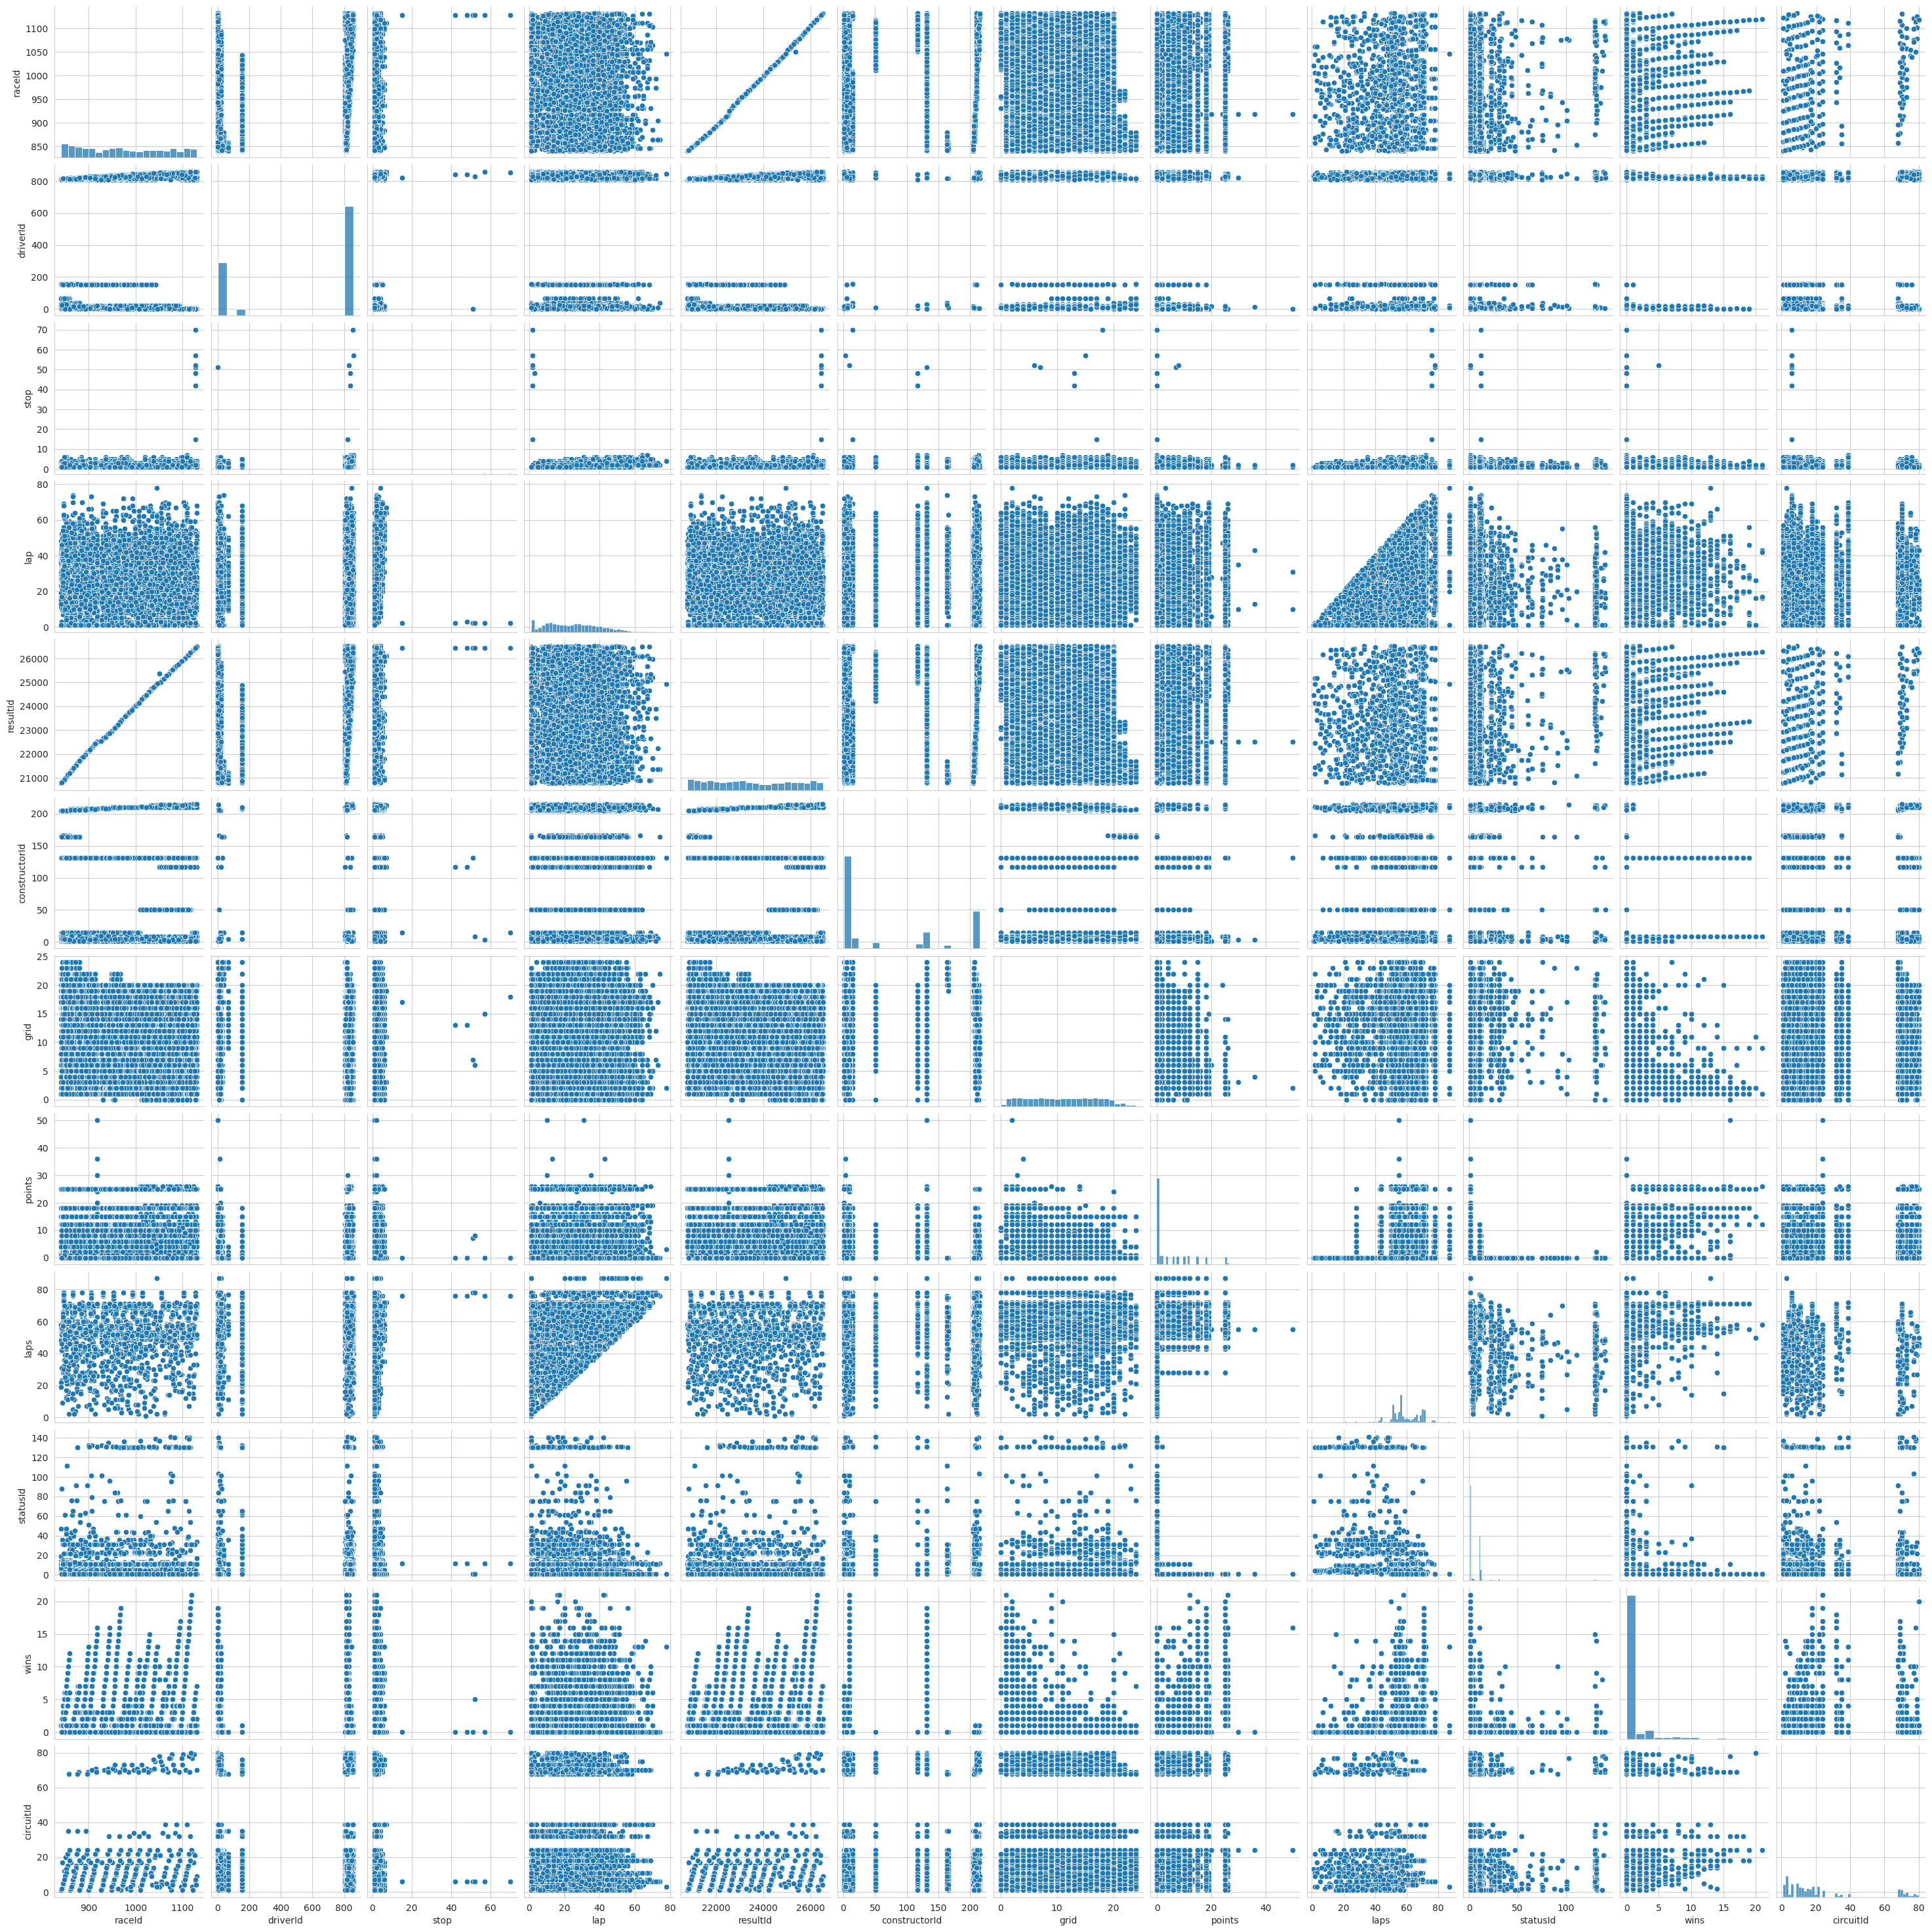

In [116]:
sns.pairplot(df_sampled);

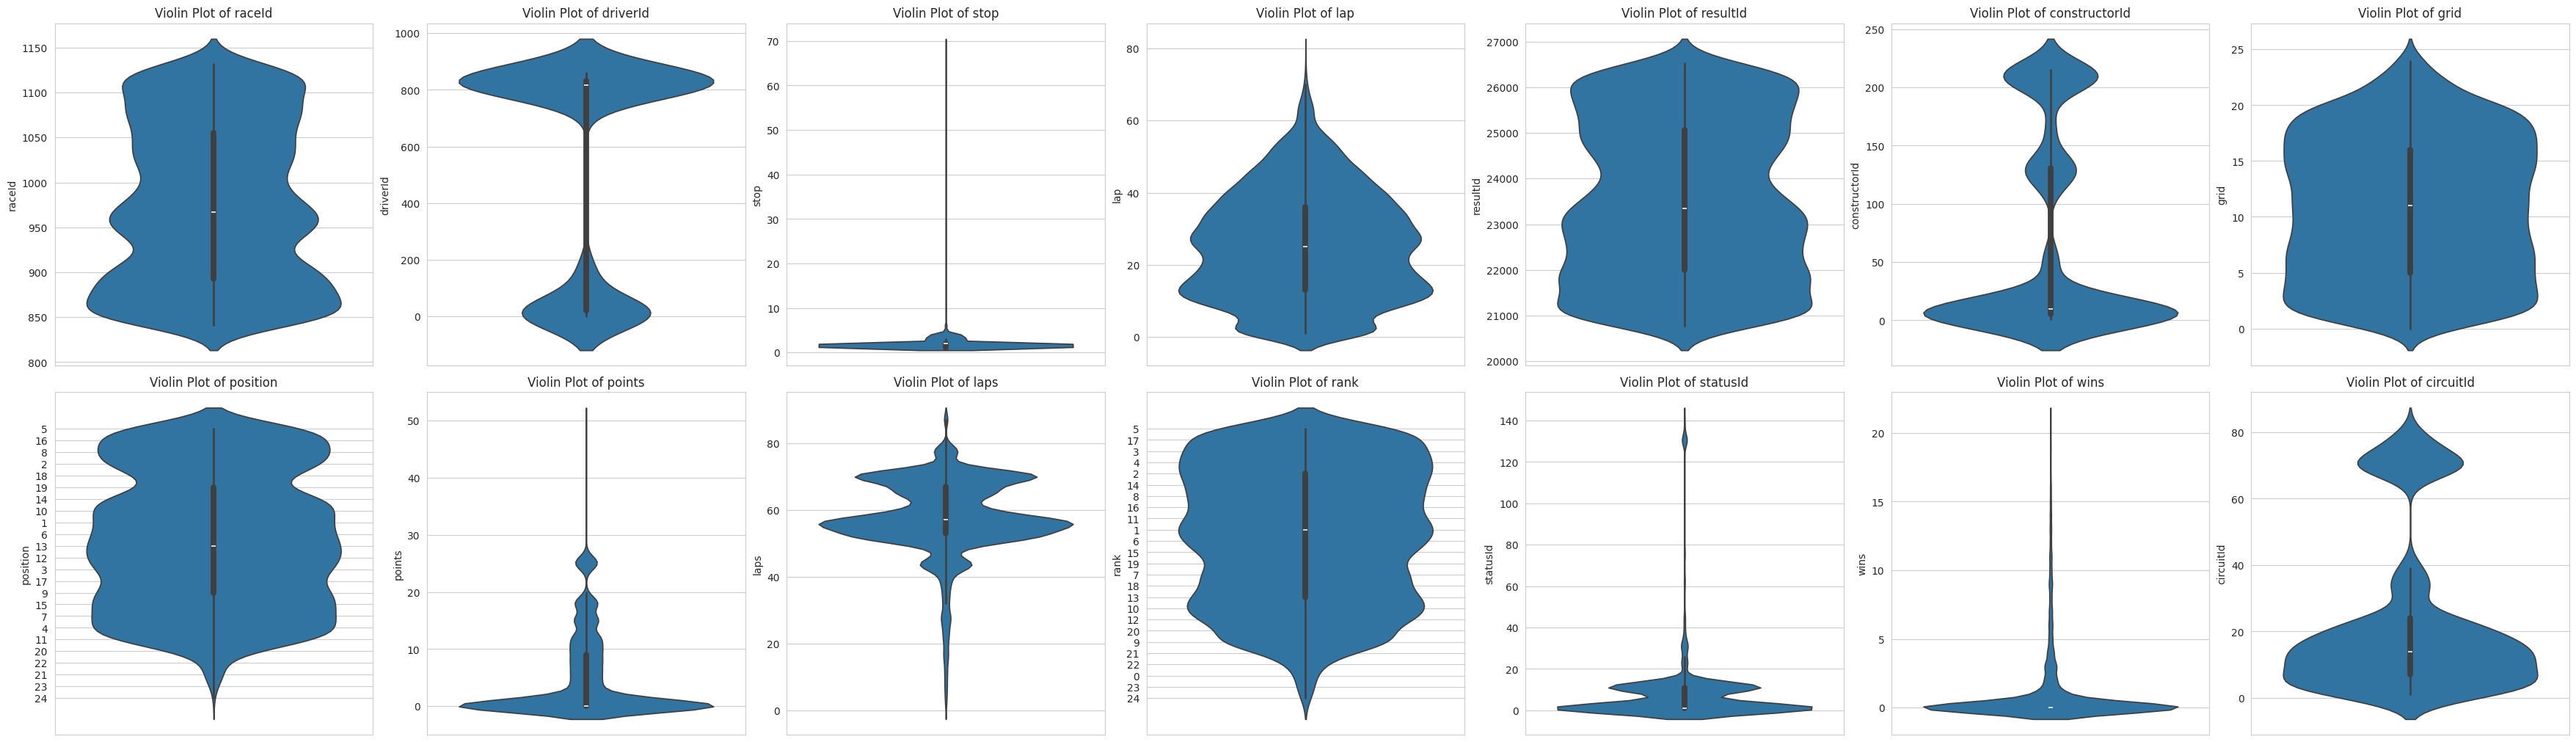

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

num_plots = len(df_cleaned.columns)

n_cols = math.ceil(num_plots / 2) 
n_rows = 2



fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5), constrained_layout=True)

axes = axes.flatten()

for idx, col in enumerate(df_cleaned.columns):
    sns.violinplot(data=df_sampled, y=col, ax=axes[idx])  
    axes[idx].set_title(f'Violin Plot of {col}')  

if num_plots < len(axes):
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i]) 

plt.show()


In [ ]:

correlation_matrix = df_cleaned.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix,annot=True,cmap='seismic',linewidths=0.5)
plt.show()

In [119]:
df_cleaned=df_cleaned[df_cleaned['stop']<=8.5]
df_cleaned=df_cleaned[df_cleaned['points']<=25]

df_cleaned=df_cleaned[df_cleaned['points']>=10]


print(df_cleaned.describe())
print(df_cleaned.shape)

            raceId     driverId         stop         lap      resultId  \
count  2661.000000  2661.000000  2661.000000  2661.00000   2661.000000   
mean    977.502818   383.894401     1.728298    26.24239  23549.499436   
std      88.150864   406.975514     0.893283    14.59172   1705.699434   
min     841.000000     1.000000     1.000000     1.00000  20779.000000   
25%     897.000000     4.000000     1.000000    14.00000  22066.000000   
50%     970.000000    20.000000     2.000000    26.00000  23403.000000   
75%    1055.000000   830.000000     2.000000    36.00000  25050.000000   
max    1132.000000   857.000000     6.000000    70.00000  26509.000000   

       constructorId         grid       points         laps     statusId  \
count    2661.000000  2661.000000  2661.000000  2661.000000  2661.000000   
mean       51.306652     4.788425    15.719278    60.416009     1.093950   
std        66.965584     3.887704     5.077345     8.664170     0.964894   
min         1.000000     0.00

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Adjust learning rate

# Example of adding dropout in the model (if using nn.Sequential, you can mix layers)
class MLPModel(nn.Module):
    def __init__(self, circuit_id_max, race_id_max, embedding_dim):
        super(MLPModel, self).__init__()
        
        # Embedding layers
        self.circuit_embedding = nn.Embedding(circuit_id_max, embedding_dim)
        self.race_embedding = nn.Embedding(race_id_max, embedding_dim)
        
        # Fully connected layers with dropout
        # self.fc1 = nn.Linear(embedding_dim * 2 + 2, 128)
        # self.dropout = nn.Dropout(0.2)  # Dropout layer with 20% probability
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, 1)
        self.fc1 = nn.Linear(embedding_dim * 2 + 2, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, circuit_id, race_id, points_wins):
      

        circuit_embedded = self.circuit_embedding(circuit_id)
        race_embedded = self.race_embedding(race_id)
        x = torch.cat([circuit_embedded, race_embedded, points_wins], dim=1)
        x = self.dropout(F.elu(self.fc1(x)))
        x = self.dropout(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Parameters
circuit_id_max = df_cleaned['circuitId'].max()  # Assuming circuitId ranges from 0 to 120
race_id_max = df_cleaned['raceId'].max()  # Number of unique raceId values
embedding_dim = 8  # Dimension for embedding layers

# Model instance
net = MLPModel(circuit_id_max, race_id_max, embedding_dim).to(device)

# Optimizer and Loss function
optimizer = optim.Adam(net.parameters(), lr=0.0001)  
criterion = nn.MSELoss()

# Data preparation
input_data = df_cleaned[['circuitId', 'raceId', 'points', 'grid']].values
target_data = df_cleaned['stop'].values

# Scale continuous features (points and wins)
scaler = StandardScaler()
# Ensure all circuitId and raceId values are within the valid range
input_data[:, 0] = input_data[:, 0].clip(0, circuit_id_max - 1)  # circuitId
input_data[:, 1] = input_data[:, 1].clip(0, race_id_max - 1)      # raceId

input_data[:, 2:] = scaler.fit_transform(input_data[:, 2:])

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.3, random_state=42)

# Tensor conversion
X_train_tensor = torch.tensor(X_train[:, :2], dtype=torch.long).to(device)  # Circuit and race IDs as long (int)
points_wins_train_tensor = torch.tensor(X_train[:, 2:], dtype=torch.float32).to(device)  # Points and wins
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

X_test_tensor = torch.tensor(X_test[:, :2], dtype=torch.long).to(device)
points_wins_test_tensor = torch.tensor(X_test[:, 2:], dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Creating a DataLoader
train_data = TensorDataset(X_train_tensor, points_wins_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data)

# Training with Early Stopping
best_loss = float('inf')
early_stop_counter = 0
patience = 20

for epoch in range(1000):
    net.train()
    for circuit_race_ids, points_wins, y_batch in train_loader:
        circuit_ids, race_ids = circuit_race_ids[:, 0], circuit_race_ids[:, 1]
        
        optimizer.zero_grad()
        pred = net(circuit_ids, race_ids, points_wins)  
        loss = criterion(pred, y_batch)
        
        loss.backward()
        optimizer.step()

    # Validation
    net.eval()
    with torch.no_grad():
        circuit_ids_test, race_ids_test = X_test_tensor[:, 0], X_test_tensor[:, 1]
        y_test_pred = net(circuit_ids_test, race_ids_test, points_wins_test_tensor)
        val_loss = criterion(y_test_pred, y_test_tensor)
    
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

# Final Test Evaluation
net.eval()
with torch.no_grad():
    final_test_loss = criterion(y_test_pred, y_test_tensor)
    print(f'\nFinal Test Loss: {final_test_loss.item()}')


cuda
Epoch 2, Training Loss: 1.9393880367279053, Validation Loss: 0.7868157625198364
Epoch 4, Training Loss: 1.1901792287826538, Validation Loss: 0.7684974074363708
Epoch 6, Training Loss: 1.177768349647522, Validation Loss: 0.7619441151618958
Epoch 8, Training Loss: 0.683769941329956, Validation Loss: 0.7610219120979309
Epoch 10, Training Loss: 0.764933168888092, Validation Loss: 0.7588188052177429
Epoch 12, Training Loss: 0.805313766002655, Validation Loss: 0.748932421207428
Epoch 14, Training Loss: 0.6392345428466797, Validation Loss: 0.7461826801300049
Epoch 16, Training Loss: 0.712369978427887, Validation Loss: 0.7458859086036682
